# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import pandas.tseries
import statsmodels.api as sm
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np
from pandas.core import datetools
from pandas import Series
import warnings
warnings.filterwarnings('ignore')

/Users/robertfustero/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


In [2]:
df = pd.read_csv('zillow_data.csv')
df['RegionName'] = df['RegionName'].astype(str)
df = df.drop(columns = ['RegionID','SizeRank'])
df = df[df.State=='WV']
df.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
967,26554,Fairmont,WV,Fairmont,Marion,49700.0,49700.0,49900.0,50100.0,50400.0,...,109400,110000,110400,111500,113100,114900,116100,117000,117900,118800
989,26505,Morgantown,WV,Morgantown,Monongalia,95100.0,95200.0,95300.0,95300.0,95300.0,...,183500,183900,184300,184900,185700,186400,186900,186900,186000,185000
2081,26508,Brookhaven,WV,Morgantown,Monongalia,83600.0,83900.0,84300.0,84800.0,85300.0,...,219900,220300,220600,220700,221300,222200,223000,223600,222700,221000
2399,25801,Beckley,WV,Beckley,Raleigh,44600.0,44600.0,44700.0,44800.0,44900.0,...,74900,75000,75100,74600,73100,72400,72500,73100,74800,76600
3012,26101,Parkersburg,WV,Parkersburg,Wood,58400.0,58300.0,58200.0,58000.0,57900.0,...,74500,74700,74900,75000,75200,75200,74900,74900,75200,75400


# Step 2: Data Preprocessing

In [3]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [4]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 8, center = False).mean()
    rolstd = TS.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['value']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

# Step 3: EDA and Visualization

In [5]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# Step 4: Reshape from Wide to Long Format

In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [6]:
def melt_data(df, region):
    melted = pd.melt(df[df.RegionName == region], id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [7]:
newdf = melt_data(df,'26554')

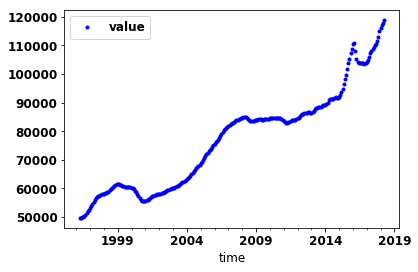

In [8]:
newdf.plot(style='b.')

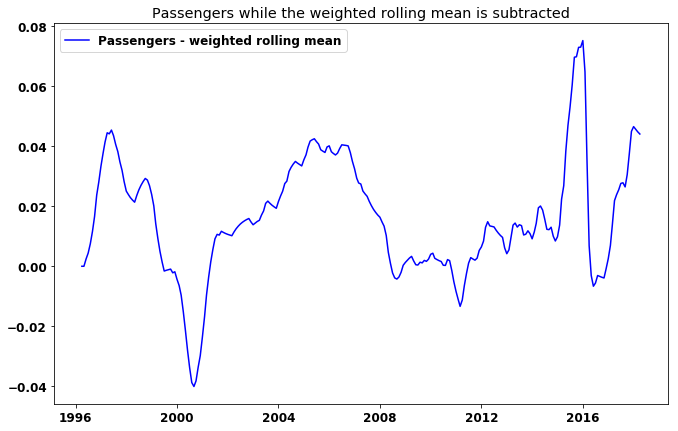

In [9]:
exp_rolmean = np.log(newdf).ewm(halflife = 4).mean()
data_minus_exp_rolmean = np.log(newdf) - exp_rolmean
data_minus_exp_rolmean.head(15)

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_rolmean, color='blue',label='Passengers - weighted rolling mean')
plt.legend(loc='best')
plt.title('Passengers while the weighted rolling mean is subtracted')
plt.show(block=False)

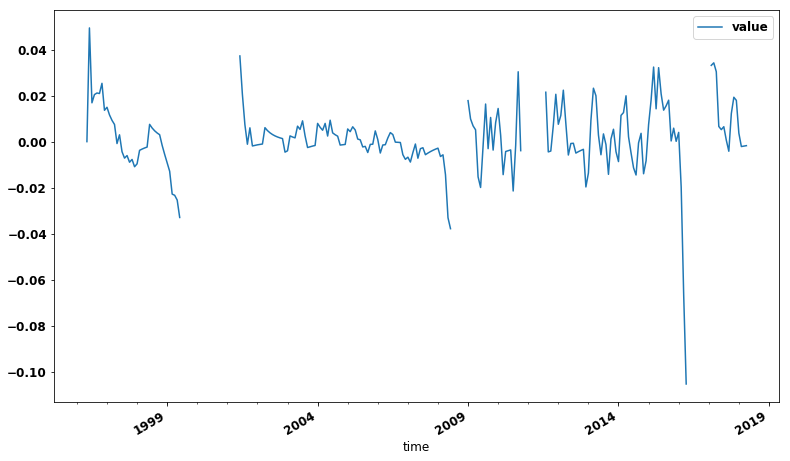

In [10]:
xr_diff = np.sqrt(data_minus_exp_rolmean).diff(periods=1)

xr_diff.plot(figsize = (13,8), subplots=True, legend=True);

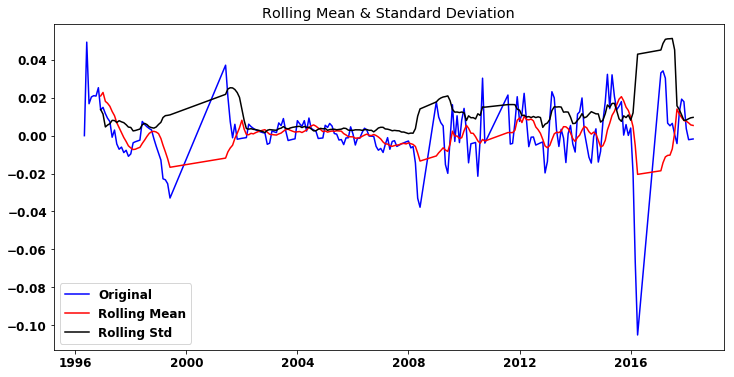

Results of Dickey-Fuller Test:
Test Statistic                -8.988120e+00
p-value                        7.010405e-15
#Lags Used                     1.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


In [11]:
xr_diff  =xr_diff.dropna()
stationarity_check(xr_diff)

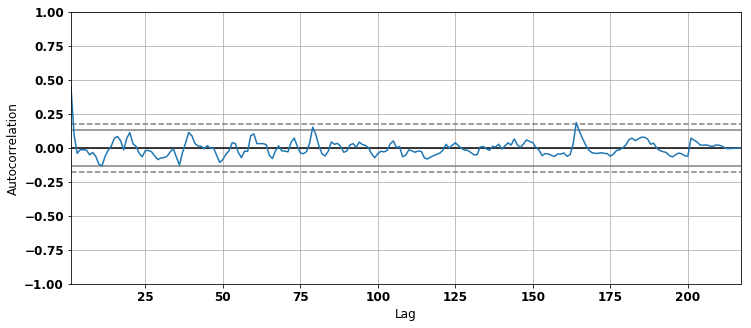

In [12]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(xr_diff);

In [13]:
nwedf = xr_diff

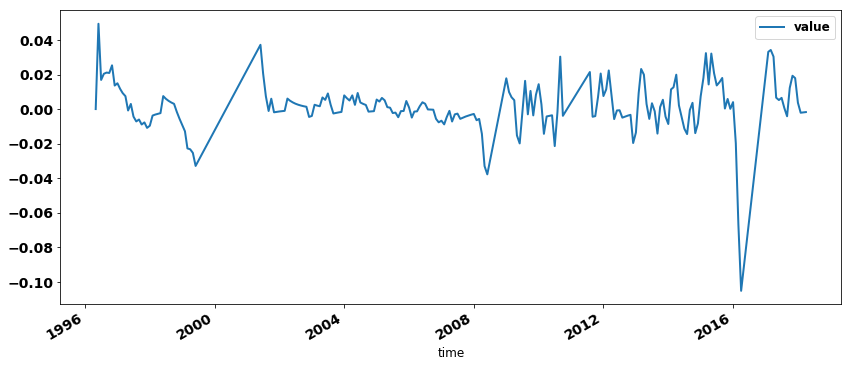

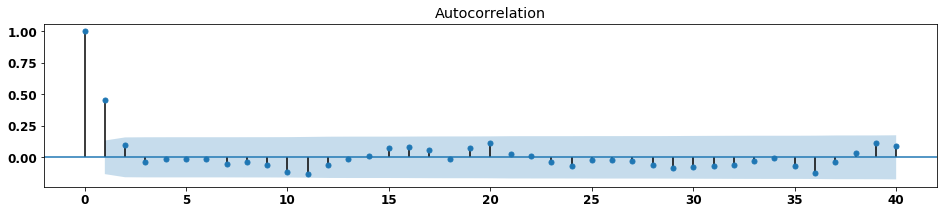

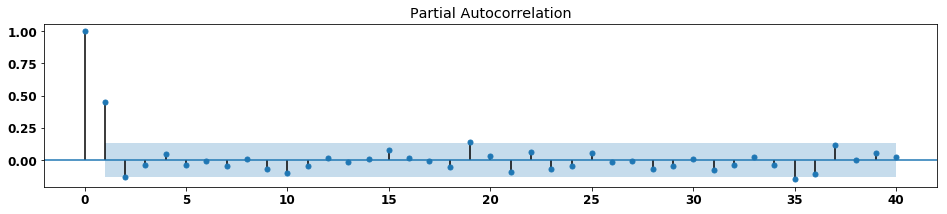

In [14]:


xr_diff.plot(figsize=(14,6), linewidth=2, fontsize=14);
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(xr_diff,ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(xr_diff,ax=ax, lags=40);

In [15]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an MA(1) model to the first simulated data
mod_arma = ARMA(list(xr_diff.values), order=(1,0))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  217
Model:                     ARMA(1, 0)   Log Likelihood                 631.400
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 09 Jul 2019   AIC                          -1256.800
Time:                        00:10:33   BIC                          -1246.661
Sample:                             0   HQIC                         -1252.704
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.746      0.456      -0.002       0.004
ar.L1.y        0.4495      0.060      7.445      0.000       0.331       0.568
                                    Roots           

# Step 5: ARIMA Modeling

In [16]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [17]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(xr_diff,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =-1203.4931914696626
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =-1147.6905839774652
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =-984.2779495441004
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =-1040.7273595283796
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =-1154.7284409338185
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =-1146.24223231289
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =-998.4249317975255
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =-1039.4251450395277
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =-1257.016406256384
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =-1182.138691729693
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =-1033.88376264654
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =-1080.1103801997315
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =-1195.7981637556486
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =-1180.4935692457948


In [18]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic          -1261.05
Name: 40, dtype: object

In [70]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(xr_diff,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2624      0.100      2.623      0.009       0.066       0.459
ma.L1          0.2593      0.133      1.948      0.051      -0.002       0.520
sigma2         0.0002   6.43e-06     25.089      0.000       0.000       0.000


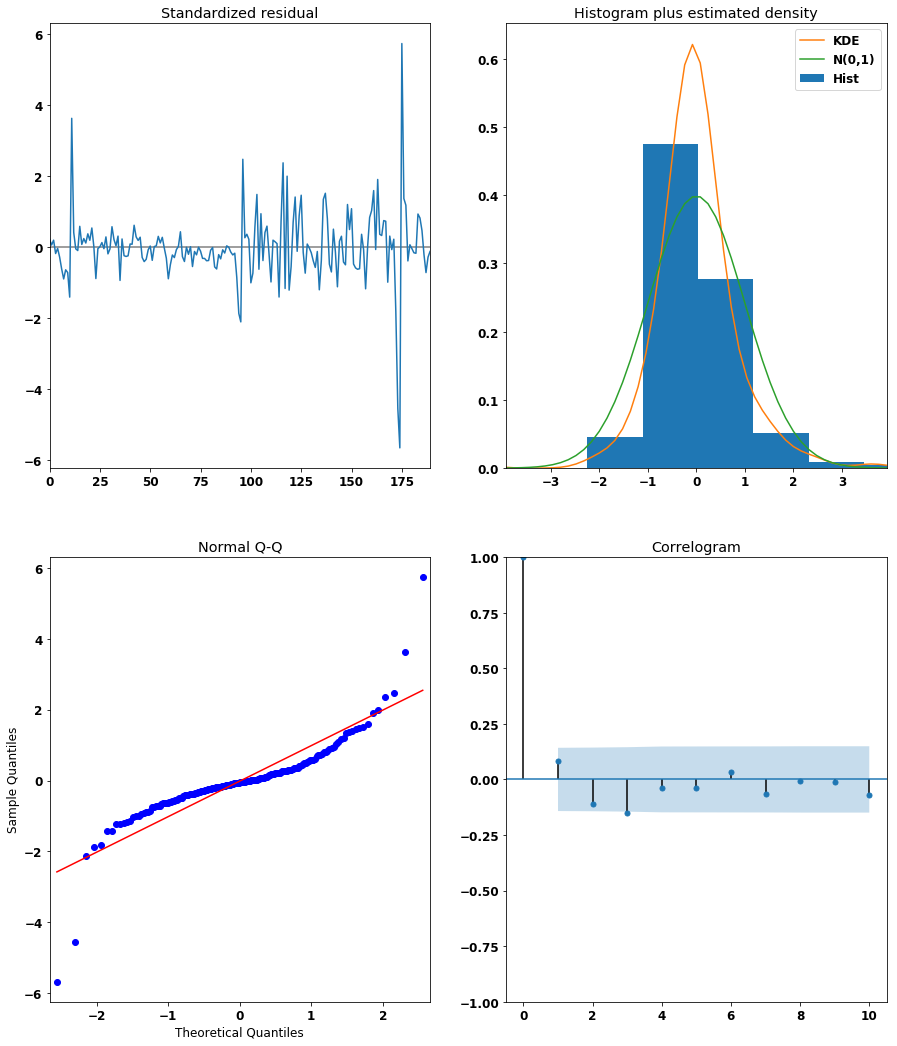

In [19]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [20]:
xr_diff

,value
time,
1996-05-01,0.000000
1996-06-01,0.049395
1996-07-01,0.016867
1996-08-01,0.020436
1996-09-01,0.021127
1996-10-01,0.020902
1996-11-01,0.025329
1996-12-01,0.013614
1997-01-01,0.014936


In [23]:
output

In [27]:
pred = output.get_prediction(dynamic=False)
pred_conf = pred.conf_int()

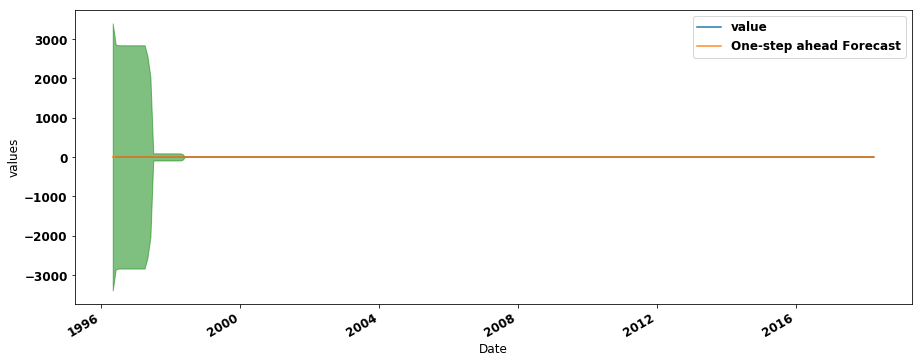

In [28]:
# Set axes labels
plt.rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = xr_diff['1996-06-01':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('values')
plt.legend()

plt.show()

In [41]:
def mean_squared_error(forcast,truth):
    return ((forcast - truth) ** 2).mean()

In [29]:
# Get the Real and predicted values
newdf_forecasted = pred.predicted_mean
newdf_truth = xr_diff.value['1996-06-01':]

# Compute the mean square error
mse = ((newdf_forecasted - newdf_truth) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))

The Mean Squared Error of our forecasts is 0.00022


In [31]:
pred_dynamic = output.get_prediction(dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

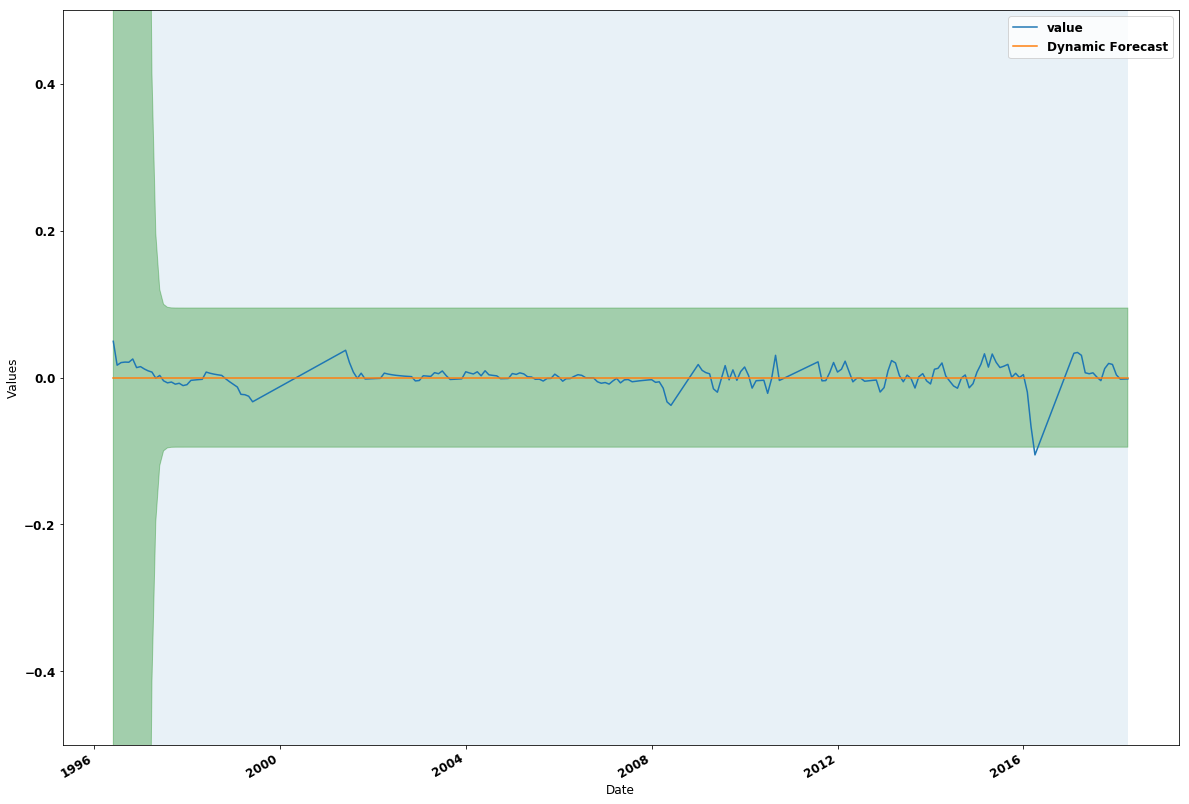

In [77]:
ax = xr_diff['1996-06-01':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1996-06-01'), newdf_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Values')
ax.set_ylim(-.5,.5)
plt.legend()
plt.show()

In [32]:
newdf_forecasted = pred_dynamic.predicted_mean
newdf_truth = xr_diff.value['1996-06-01':]

# Compute the mean square error
mse = ((newdf_forecasted - newdf_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 5)))


The Mean Squared Error of our forecasts is 0.00022


In [34]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

# Fit an ARMA(2,2) model to the first simulated data
mod_arma = ARMA(xr_diff, order=(1,1))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

                              ARMA Model Results                              
Dep. Variable:                  value   No. Observations:                  217
Model:                     ARMA(1, 1)   Log Likelihood                 632.973
Method:                       css-mle   S.D. of innovations              0.013
Date:                Tue, 09 Jul 2019   AIC                          -1257.946
Time:                        00:42:19   BIC                          -1244.426
Sample:                             0   HQIC                         -1252.484
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0012      0.001      0.787      0.432      -0.002       0.004
ar.L1.value     0.2741      0.123      2.226      0.027       0.033       0.515
ma.L1.value     0.2282      0.121      1.886    

# Step 6: Interpreting Results

In [35]:
def get_results(df, preds, name):
    if 'pandas.core.frame.DataFrame' in str(type(df)):
        current_price = df.iloc[-1].value
    else:
        current_price = df[-1]
    year_later = preds[11]
    year_3_val = preds[35]
    year_5_val = preds[-1]
    print("Current Avg Median Home Value in {}: ${:.2f}".format(name, current_price))
    print("Predicted Avg Median Home Value for {} in April 2019: ${:.2f}".format(name, year_later))
    expected_appreciation_value_1 = year_later - current_price
    expected_appreciation_percent_1 = expected_appreciation_value_1 / current_price
    expected_appreciation_value_3 = year_3_val - current_price
    expected_appreciation_percent_3 = expected_appreciation_value_3 / current_price
    expected_appreciation_value_5 = year_5_val - current_price
    expected_appreciation_percent_5 = expected_appreciation_value_5 / current_price
    print("Expected property value appreciation for 1 year in {} :  ${:.2f}".format(name, expected_appreciation_value_1))
    print("Expected Return on Investment after 1 year:  {:.4f}%".format(expected_appreciation_percent_1 * 100))
    print("Expected property value appreciation for 3 years in {} :  ${:.2f}".format(name, expected_appreciation_value_3))
    print("Expected Return on Investment after 3 years:  {:.4f}%".format(expected_appreciation_percent_3 * 100))
    print("Expected property value appreciation for 5 years in {} :  ${:.2f}".format(name, expected_appreciation_value_5))
    print("Expected Return on Investment after 5 years:  {:.4f}%".format(expected_appreciation_percent_5 * 100))

In [39]:
def fit_model(df, zipcode, show_graph=True):
    # Get only the values from the dataframe
    vals = df.values
    # Split the data into training and testing sets by holding out dates past a certain point. Below, we use index 261 for
    # this split
    train = vals[:261]
    test = vals[261:]
    # Use a list comprehension to create a "history" list using our training data values
    history = [i for i in train]
    # initialize an empty list for predictions
    preds = []
    # loop through a list the length of our training set
    for i in range(len(test)):
        # create an ARIMA model and pass in our history list. Also set `order=(0,1,1)` (order refers to AR and MA params--
        # see statsmodels documentation for ARIMA for more details)
        model = ARMA(history, order=(0,1,1))
        # Fit the model we just created
        fitted_model = model.fit(disp=0)
        # Get the forecast of the next value from our fitted model, and grab the first value to use as our 'y-hat' prediction
        output = fitted_model.forecast()
        y_hat = output[0]
        # append y_hat to our list of predictions
        preds.append(y_hat)
        obs = test[i]
        # Get the actual ground truth value for this datetime and append it to the history array
        history.append(obs)
    # get the forecast for the next three years (1 month==1 timestep in our data)
    future_preds = fitted_model.forecast(steps=36)[0]
    # Visualize the ARIMA model's predictions vs the actual ground truth values for our test set
    if show_graph == True:
        print('Predicted: {} \t Expected: {}'.format(y_hat, obs))
        # Also calculate the MSE
        mse = mean_squared_error(test, preds)
        print("MSE for Test Set: {}".format(mse))
        plt.plot(test)
        plt.plot(preds, color='r')
        plt.ylabel('Median Home Value ($)')
        plt.title('Predicted vs Expected Median Home Sale Values'.format(zipcode))
        plt.legend(['Actual', 'Predicted'])
        plt.show()
        plt.figure()
        plt.plot(future_preds)
        plt.ylabel('Median Home Value ($)')
        plt.title('Predicted Home Value, {}, Next 36 Months'.format(zipcode))
        plt.show()
        get_results(df, future_preds, zipcode)
    return future_preds

In [37]:
get_results(xr_diff,newdf_forecasted,'bob')

Current Avg Median Home Value in bob: $-0.00
Predicted Avg Median Home Value for bob in April 2019: $0.00
Expected property value appreciation for 1 year in bob :  $0.00
Expected Return on Investment after 1 year:  -100.0000%
Expected property value appreciation for 3 years in bob :  $0.00
Expected Return on Investment after 3 years:  -100.0000%
Expected property value appreciation for 5 years in bob :  $0.00
Expected Return on Investment after 5 years:  -100.0000%


Predicted: [97828.79460552] 	 Expected: [118800.]
MSE for Test Set: 420699298.3419061


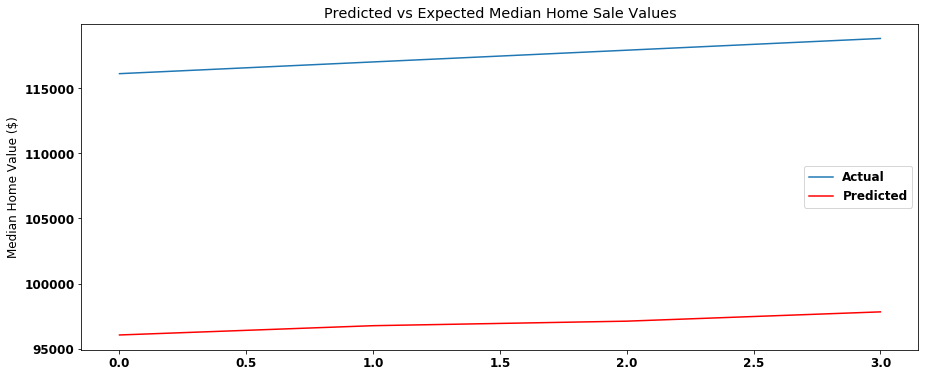

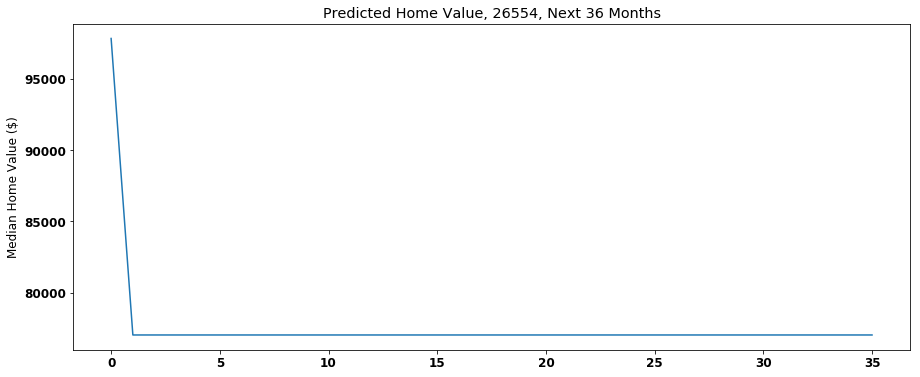

Current Avg Median Home Value in 26554: $118800.00
Predicted Avg Median Home Value for 26554 in April 2019: $77038.65
Expected property value appreciation for 1 year in 26554 :  $-41761.35
Expected Return on Investment after 1 year:  -35.1527%
Expected property value appreciation for 3 years in 26554 :  $-41761.35
Expected Return on Investment after 3 years:  -35.1527%
Expected property value appreciation for 5 years in 26554 :  $-41761.35
Expected Return on Investment after 5 years:  -35.1527%


array([97828.79460552, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709,
       77038.64981709, 77038.64981709, 77038.64981709, 77038.64981709])

In [42]:
fit_model(newdf,'26554')